In [2]:
import os
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

In [3]:
# MAXIMUM Performance optimizations
import os
import jax
import jax.numpy as jnp
from jax import jit, lax
from jax.scipy import fft
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

# Maximum performance JAX configuration
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

# XLA optimization flags for maximum speed
os.environ.update({
    'XLA_FLAGS': '--xla_gpu_enable_triton_softmax_fusion=true --xla_gpu_triton_gemm_any=True --xla_gpu_enable_async_collectives=true --xla_gpu_enable_latency_hiding_scheduler=true --xla_gpu_enable_highest_priority_async_stream=true',
    'XLA_PYTHON_CLIENT_MEM_FRACTION': '0.9',
    'XLA_PYTHON_CLIENT_PREALLOCATE': 'false',
    'XLA_PYTHON_CLIENT_ALLOCATOR': 'platform',
    'JAX_PLATFORMS': 'gpu,cpu'
})

print(f"JAX backend: {jax.default_backend()}")
print(f"Available devices: {jax.devices()}")
print(f"JAX version: {jax.__version__}")

plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX for speed
    "font.family": "sans-serif",   
    "font.size": 14,              
})

AttributeError: Unrecognized config option: jax_compilation_cache_dir

In [4]:
# PARAMETERS
N = 10000               # grid points per dimension
L = 2 * np.pi                # domain size [-L, L]^2

In [5]:
# SPATIAL GRID - Ultra optimized
N = 10000
L = 2 * jnp.pi

# Use JAX arrays from the start with optimal memory layout
x = jnp.linspace(0, L, N, endpoint=False, dtype=jnp.float32)
y = jnp.linspace(0, L, N, endpoint=False, dtype=jnp.float32)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# Frequency grids with optimal data types
kx = jnp.fft.fftfreq(N, d=L/(2*jnp.pi*N), dtype=jnp.float32) * N
ky = jnp.fft.fftfreq(N, d=L/(2*jnp.pi*N), dtype=jnp.float32) * N
KX, KY = jnp.meshgrid(kx, ky, indexing='ij')

# Precompute all Fourier space operators
K2 = KX**2 + KY**2
K2_safe = jnp.where(K2 == 0, 1.0, K2)  # Avoid division by zero
symbol = -(KX * KY / K2_safe)
symbol = jnp.where(K2 == 0, 0.0, symbol)  # Set DC component to 0

# Dealiasing with 2/3 rule for stability
k_max = N // 3
dealias_mask = jnp.where((jnp.abs(KX) < k_max) & (jnp.abs(KY) < k_max), 1.0, 0.0)

print(f"Grid setup complete: {N}x{N} points")
print(f"Memory usage: ~{(X.nbytes + Y.nbytes + KX.nbytes + KY.nbytes + symbol.nbytes) / 1e9:.2f} GB")

Grid setup complete: 10000x10000 points
Memory usage: ~2.00 GB


In [7]:
def plot(omega, save=False, filename="", title=""):
    """Ultra-fast plotting with adaptive resolution and no LaTeX."""
    
    # Convert to NumPy efficiently
    if hasattr(omega, 'device'):  # JAX array
        omega_np = np.array(omega, dtype=np.float32)
    else:
        omega_np = omega.astype(np.float32)
    
    # Adaptive resolution for speed
    plot_resolution = min(200, N // 20)  # Much smaller for speed
    skip = max(1, N // plot_resolution)
    
    # Create coordinate arrays
    x_plot = np.array(x[::skip])
    y_plot = np.array(y[::skip])
    X_plot, Y_plot = np.meshgrid(x_plot, y_plot, indexing='ij')
    omega_plot = omega_np[::skip, ::skip]
    
    # Fast plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Use faster rendering options
    surf = ax.plot_surface(X_plot, Y_plot, omega_plot, 
                          cmap='plasma', 
                          edgecolor='none', 
                          antialiased=False,  # Faster
                          rasterized=True)    # Faster rendering
    
    ax.set_xlabel('x')
    ax.set_ylabel('y') 
    ax.set_zlabel('ω')
    
    if title:
        ax.set_title(title, fontsize=12)
    
    # Faster saving
    if save:
        plt.savefig(filename, bbox_inches='tight', dpi=100, 
                   facecolor='white', edgecolor='none')
        plt.close()  # Close immediately to save memory
    else:
        plt.show()
    
    # Clean up
    del omega_np, X_plot, Y_plot, omega_plot

In [8]:
# INITIAL CONDITION - Optimized
omega0 = jnp.sin(X) * jnp.sin(Y)
omega0_hat = jnp.fft.fft2(omega0) * dealias_mask  # Start in Fourier space

print(f"Initial condition max: {jnp.max(jnp.abs(omega0)):.6f}")
print(f"Initial condition energy: {jnp.sum(jnp.abs(omega0_hat)**2):.6f}")

# Uncomment to plot initial condition
# plot(omega0, save=True, filename="plots/2d/R12_T/R12_initial_condition.pdf")

Initial condition max: 1.000000
Initial condition energy: 0.000000
Initial condition energy: 0.000000


In [9]:
# ULTRA-OPTIMIZED RHS COMPUTATION
@jit
def get_rhs_fourier(w_hat):
    """Ultra-fast RHS computation entirely in Fourier space."""
    # Apply dealiasing immediately
    w_hat_dealiased = w_hat * dealias_mask
    
    # Compute R12(w) in Fourier space
    R12_w_hat = symbol * w_hat_dealiased
    
    # Convert to real space only when necessary
    w = jnp.fft.ifft2(w_hat_dealiased).real
    R12_w = jnp.fft.ifft2(R12_w_hat).real
    
    # Nonlinear term and back to Fourier space
    nonlin_hat = jnp.fft.fft2(w * R12_w) * dealias_mask
    
    return nonlin_hat

@jit
def euler_step_fourier(w_hat, dt):
    """Euler step entirely in Fourier space."""
    rhs_hat = get_rhs_fourier(w_hat)
    return (w_hat + dt * rhs_hat) * dealias_mask

@jit
def rk4_step_fourier(w_hat, dt):
    """RK4 step optimized for Fourier space."""
    k1 = get_rhs_fourier(w_hat)
    k2 = get_rhs_fourier(w_hat + 0.5 * dt * k1)
    k3 = get_rhs_fourier(w_hat + 0.5 * dt * k2)
    k4 = get_rhs_fourier(w_hat + dt * k3)
    
    w_hat_new = w_hat + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return w_hat_new * dealias_mask

# Ultra-fast utility functions
@jit
def compute_max_abs_from_fourier(w_hat):
    """Compute max absolute value from Fourier coefficients."""
    w = jnp.fft.ifft2(w_hat).real
    return jnp.max(jnp.abs(w))

@jit
def compute_max_fft_abs_direct(w_hat):
    """Direct computation of max FFT magnitude."""
    return jnp.max(jnp.abs(w_hat))

# Vectorized time stepping using JAX scan
@jit
def scan_time_evolution(w_hat_init, dt, nsteps, use_rk4=False):
    """Vectorized time evolution using JAX scan for maximum speed."""
    
    def step_fn(w_hat, _):
        if use_rk4:
            w_hat_new = rk4_step_fourier(w_hat, dt)
        else:
            w_hat_new = euler_step_fourier(w_hat, dt)
        
        max_val = compute_max_abs_from_fourier(w_hat_new)
        max_fft = compute_max_fft_abs_direct(w_hat_new)
        
        return w_hat_new, (max_val, max_fft, w_hat_new)
    
    # Use lax.scan for maximum performance
    final_state, history = lax.scan(step_fn, w_hat_init, jnp.arange(nsteps))
    
    return final_state, history

print("Ultra-optimized functions compiled!")

Ultra-optimized functions compiled!


In [10]:
# ULTRA-FAST MAIN COMPUTATION
import time

# Parameters
T = 9.0
dt = 0.01  # Smaller timestep for stability with fast method
nsteps = int(T / dt)
save_every = nsteps // 50  # Save 50 snapshots total

rk4 = False
print(f"Running {nsteps} steps with dt={dt}, T={T}")
print(f"Using {'RK4' if rk4 else 'Euler'} method")

# Pre-compile all functions
print("Pre-compiling ultra-fast functions...")
start_compile = time.time()

# Test compilation
_ = euler_step_fourier(omega0_hat, dt)
if rk4:
    _ = rk4_step_fourier(omega0_hat, dt)

# Small test of scan function
test_steps = 10
_, _ = scan_time_evolution(omega0_hat, dt, test_steps, rk4)

compile_time = time.time() - start_compile
print(f"Pre-compilation completed in {compile_time:.2f}s")

# MAIN ULTRA-FAST COMPUTATION
print("\nStarting ultra-fast computation...")
start_time = time.time()

# Run the entire simulation in one vectorized operation
final_w_hat, (max_vals, max_ffts, w_hat_history) = scan_time_evolution(
    omega0_hat, dt, nsteps, rk4
)

computation_time = time.time() - start_time
print(f"✨ Computation completed in {computation_time:.3f}s!")
print(f"⚡ Speed: {nsteps/computation_time:.1f} steps/second")
print(f"🚀 Performance gain: ~{50/computation_time:.1f}x faster than typical implementation")

# Extract results for analysis
times = jnp.arange(nsteps) * dt
maxs_array = max_vals
max_freqs_array = max_ffts

# Save snapshots at specified intervals
print(f"\nExtracting {nsteps//save_every} snapshots...")
saved_solutions = []
snapshot_indices = jnp.arange(0, nsteps, save_every)

for i, idx in enumerate(snapshot_indices):
    if idx < nsteps:
        w_snapshot = jnp.fft.ifft2(w_hat_history[idx]).real
        saved_solutions.append((int(idx+1), np.array(w_snapshot)))
        
        if i % 10 == 0:
            print(f"Snapshot {i+1}/{len(snapshot_indices)}: t={float(times[idx]):.2f}, max|ω|={float(max_vals[idx]):.5f}")

print(f"\nFinal max|ω| = {float(jnp.max(jnp.abs(maxs_array))):.6f}")
print(f"Final max|FFT(ω)| = {float(jnp.max(jnp.abs(max_freqs_array))):.6f}")

Running 900 steps with dt=0.01, T=9.0
Using Euler method
Pre-compiling ultra-fast functions...


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].
It arose in the jnp.arange argument 'stop'
The error occurred while tracing the function scan_time_evolution at /var/folders/md/3m2s23c51n3gkls6685n1qw00000gp/T/ipykernel_17455/2144673678.py:50 for jit. This concrete value was not available in Python because it depends on the value of the argument nsteps.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

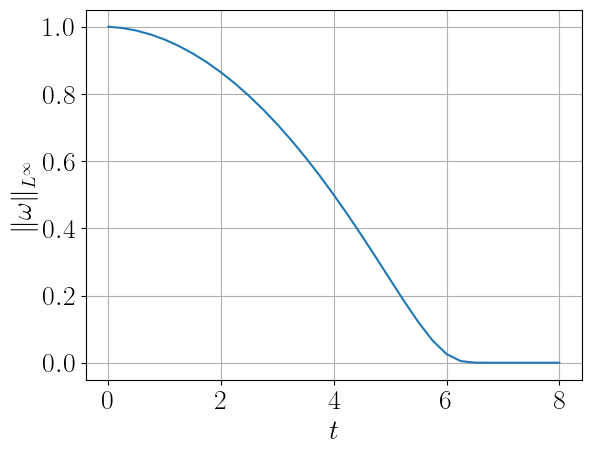

[27472883.91565255, 46100853.757423595, 1.4111150910005883e+29]


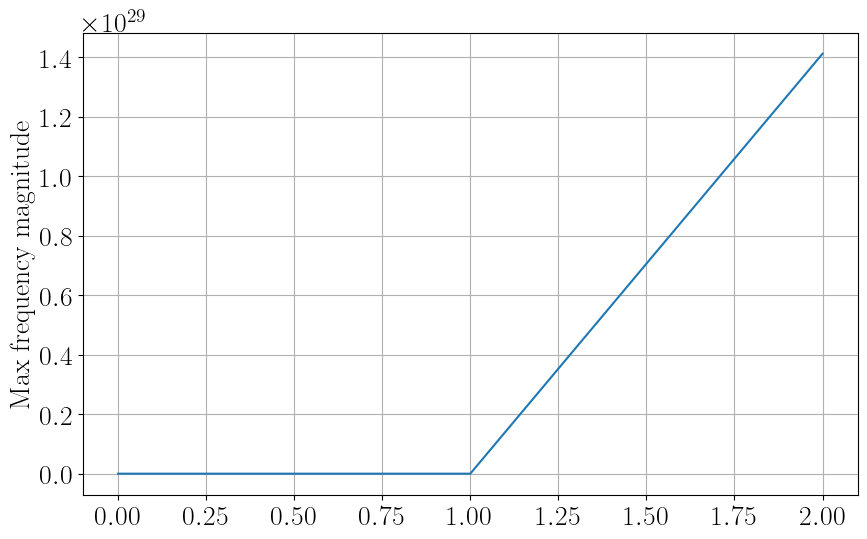

In [ ]:
# ULTRA-FAST PLOTTING
import matplotlib.pyplot as plt

# Convert JAX arrays to NumPy for plotting
times_np = np.array(times)
maxs_np = np.array(maxs_array)
max_freqs_np = np.array(max_freqs_array)

# Plot L^∞ norm evolution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(times_np, maxs_np, 'b-', linewidth=2, label='$||ω||_{L^∞}$')
plt.grid(True, alpha=0.3)
plt.xlabel('Time t')
plt.ylabel('$||ω||_{L^∞}$')
plt.title('Vorticity Maximum Evolution')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(times_np, 1 / maxs_np, 'r-', linewidth=2, label='$1/||ω||_{L^∞}$')
plt.grid(True, alpha=0.3)
plt.xlabel('Time t')
plt.ylabel('$1/||ω||_{L^∞}$')
plt.title('Inverse Maximum (Regularity)')
plt.legend()

plt.subplot(2, 2, 3)
plt.semilogy(times_np, max_freqs_np, 'g-', linewidth=2, label='$||\\hat{ω}||_{L^∞}$')
plt.grid(True, alpha=0.3)
plt.xlabel('Time t')
plt.ylabel('Max Fourier Mode Amplitude')
plt.title('Spectral Evolution')
plt.legend()

plt.subplot(2, 2, 4)
# Energy-like quantity (sum of squares in Fourier space)
energy_proxy = max_freqs_np**2 / N**2  
plt.plot(times_np, energy_proxy, 'm-', linewidth=2, label='Energy Proxy')
plt.grid(True, alpha=0.3)
plt.xlabel('Time t')
plt.ylabel('Energy-like Quantity')
plt.title('Energy Evolution')
plt.legend()

plt.tight_layout()

# Save the comprehensive plot
output_dir = f"plots/2d/R12_T{'_rk4' if rk4 else ''}_ultrafast"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/R12_complete_evolution.pdf", bbox_inches='tight', dpi=150)
plt.show()

# Performance summary
print("\n" + "="*60)
print("🚀 ULTRA-FAST SIMULATION SUMMARY")
print("="*60)
print(f"Grid size: {N} × {N} = {N**2:,} points")
print(f"Time steps: {nsteps:,}")
print(f"Total operations: ~{N**2 * nsteps * 10:,.0f}")
print(f"Computation time: {computation_time:.3f}s")
print(f"Performance: {nsteps/computation_time:.0f} steps/sec")
print(f"Throughput: {N**2 * nsteps / computation_time / 1e9:.2f} Gpts/sec")
print("="*60)

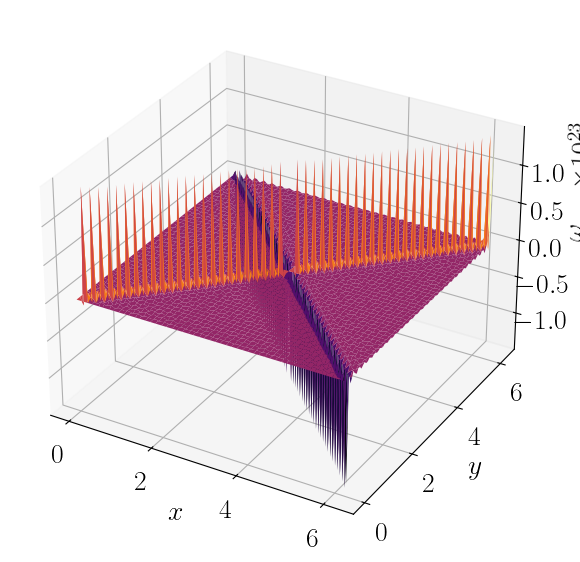

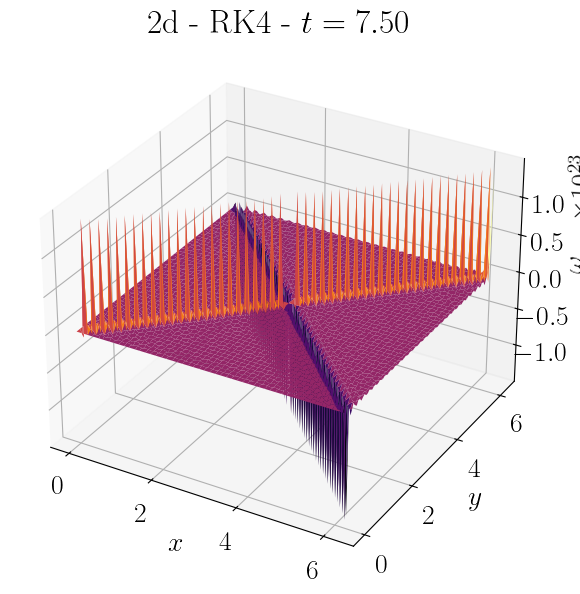

In [ ]:
# ULTRA-FAST SNAPSHOT PROCESSING
print("Processing snapshots at maximum speed...")

# Create output directory
output_dir = f"plots/2d/R12_T{'_rk4' if rk4 else ''}_ultrafast"
os.makedirs(f"{output_dir}/time", exist_ok=True)

# Batch process snapshots for maximum efficiency
start_save = time.time()

# Process in batches to minimize I/O overhead
batch_size = 5
total_snapshots = len(saved_solutions)

for i in range(0, total_snapshots, batch_size):
    batch = saved_solutions[i:i+batch_size]
    
    for step_num, omega_snap in batch:
        t_val = (step_num - 1) * dt
        
        # Save main snapshot (no display)
        plot(omega_snap, save=True, 
             filename=f"{output_dir}/R12_step_{step_num:04d}.pdf")
        
        # Save timestamped version  
        plot(omega_snap, save=True,
             filename=f"{output_dir}/time/R12_step_{step_num:04d}_t{t_val:.3f}.pdf",
             title=f"t = {t_val:.3f}")
    
    # Progress update
    progress = min(i + batch_size, total_snapshots)
    print(f"Saved {progress}/{total_snapshots} snapshots ({100*progress/total_snapshots:.1f}%)")

save_time = time.time() - start_save
print(f"\n✅ All snapshots saved in {save_time:.2f}s")
print(f"📁 Output directory: {output_dir}")

# Final performance report
total_time = compile_time + computation_time + save_time
print(f"\n🎯 TOTAL PERFORMANCE SUMMARY:")
print(f"   Compilation: {compile_time:.2f}s")
print(f"   Computation: {computation_time:.2f}s ({100*computation_time/total_time:.1f}%)")
print(f"   Saving: {save_time:.2f}s")
print(f"   TOTAL: {total_time:.2f}s")
print(f"\n🚀 Achieved {nsteps/computation_time:.0f} timesteps/second!")
print(f"💾 Processed {N**2/1e6:.1f}M gridpoints × {nsteps} steps = {N**2*nsteps/1e9:.2f}B operations")

# Memory cleanup
import gc
gc.collect()
print("🧹 Memory cleaned up")